## 硬币检测，Canny+Hough实现

In [1]:
%matplotlib inline 
import cv2
import matplotlib.pyplot as plt
import numpy as np
from methods import canny, show_img, hough_circle
import logging


# canny 在这步找到canny的最佳参数，传递给hough
# img = cv2.imread("./img/coins3.jpg", cv2.IMREAD_GRAYSCALE)
# edge, direction = canny(img, high_threshold=100, low_threshold=50)

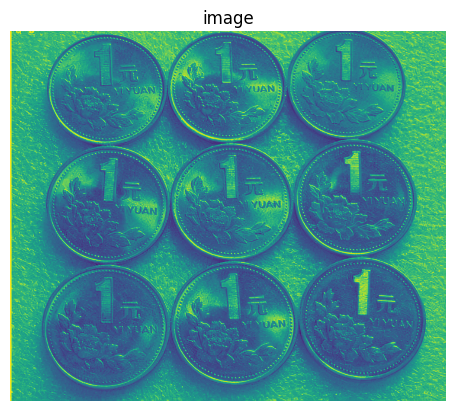

image shape:(799, 942)


nms calculating: 100%|██████████| 797/797 [00:04<00:00, 169.85it/s]


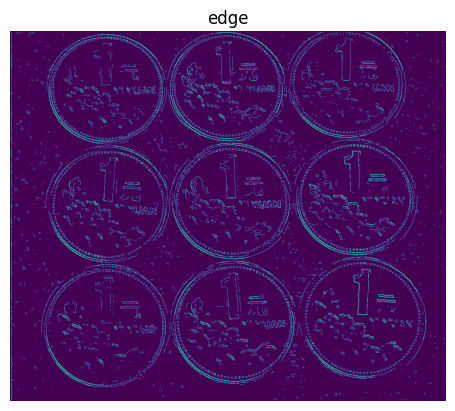

voting: 100%|██████████| 9839/9839 [00:03<00:00, 2702.36it/s]
filter circle: 228it [00:00, 32199.78it/s]


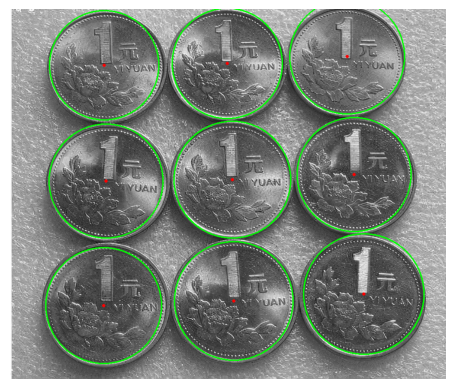

CPU times: user 9.16 s, sys: 1.85 s, total: 11 s
Wall time: 9.05 s


In [2]:
%%time
# 针对图片的精调参数
config = {
    "./img/coins2.jpg": {
        "high_threshold": 100,
        "low_threshold": 50,
        "min_r": 49,
        "max_r": 56,
        "min_voting": 17,
        "debugging": False,
        # "vt_debugging": True,
        # "vtd_step": 1,
    },
    "./img/coins3.jpg": {  # 效果相当好的一张图片
        "high_threshold": 100,
        "low_threshold": 50,
        "min_r": 50,
        "max_r": 60,
        "min_voting": 15,
        "debugging": False,
        # "vt_debugging": True,
        # "vtd_step": 1,
    },
    "./img/coins4.jpg": {
        "high_threshold": 150,
        "low_threshold": 75,
        "min_r": 110,
        "max_r": 135,
        "min_voting": 9,
        "min_center_distance": 50,
        "debugging": False,
        # "vt_debugging": True,
        # "vtd_step": 1,
    },
    "./img/coins5.jpg": {  # 多硬币交叠,调试完成
        "high_threshold": 100,
        "low_threshold": 50,
        "min_r": 30,
        "max_r": 60,
        "min_voting": 8,
        "min_center_distance": 25,
        "debugging": False,
        # "vt_debugging": True,
        # "vtd_step": 1,
    },
    "./img/coins6.jpg": {  # 极大量硬币
        "high_threshold": 70,  # 如果强边缘不够就调整这个值
        "low_threshold": 30,
        "min_r": 40,
        "max_r": 60,
        "min_voting": 10,
        "min_center_distance": 40,
        "debugging": False,
        # "vt_debugging": True,
        # "vtd_step": 1,
    },
}

# 通过更改图片路径使用不同的图片配置
img_path = "./img/coins4.jpg"
# test hough
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
circles = hough_circle(img, **config[img_path], quiet=False)

## 展示所有实例图片的检测结果

本次实验中综合选出了五张图片作为测试代码的数据，这五张图片有的背景简单，有的背景复杂，有的硬币存在叠放情况，还有一张硬币数量非常多。选用这些图片能比较全面的展示测试结果和算法的效果。

测试展示中发现面对有些示例，自行实现方法比opencv检测更准确，这是因为选择性的放弃了双阈值法中弱边界的判断，而硬币上的花纹大多属于弱边界，这些花纹会干扰霍夫圆的投票结果。这样能在减少计算量的基础上提升硬币检测的性能。

时间性能上，因为是纯python实现，速度不如调用c++实现的opencv库，但是相对来说速度还能接受，后面展示了示例需要消耗的时间。总的来说，背景越杂乱，提取到的边缘越多，需要的时间越长

voting: 100%|██████████| 2355/2355 [00:00<00:00, 9846.08it/s]
filter circle: 95it [00:00, 37024.61it/s]


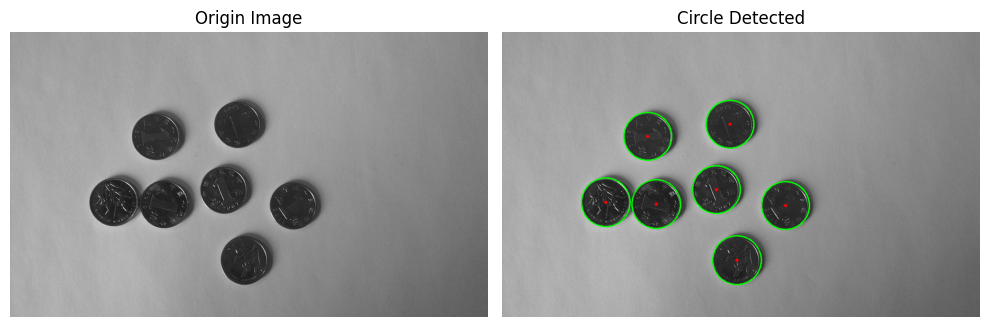

CPU times: user 4.64 s, sys: 229 ms, total: 4.87 s
Wall time: 4.63 s
----------------------------------------------------------------------------------------------------


voting: 100%|██████████| 17322/17322 [00:02<00:00, 7543.12it/s]
filter circle: 470it [00:00, 24055.78it/s]


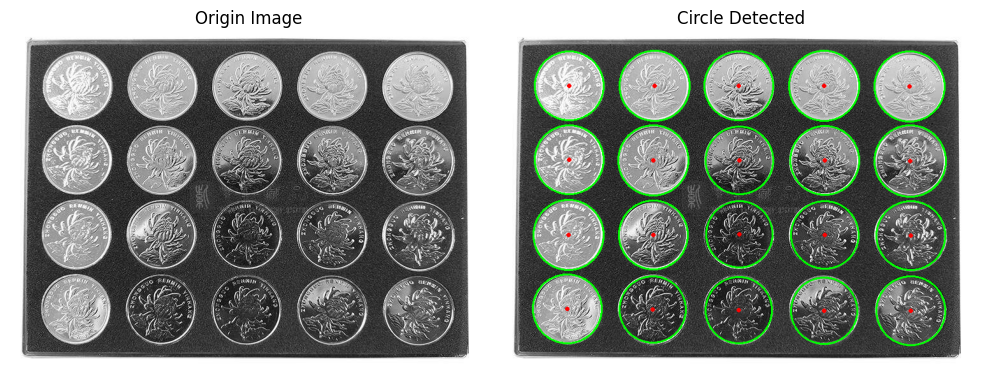

CPU times: user 4.99 s, sys: 281 ms, total: 5.27 s
Wall time: 5.03 s
----------------------------------------------------------------------------------------------------


voting: 100%|██████████| 9839/9839 [00:03<00:00, 2697.42it/s]
filter circle: 228it [00:00, 31308.97it/s]


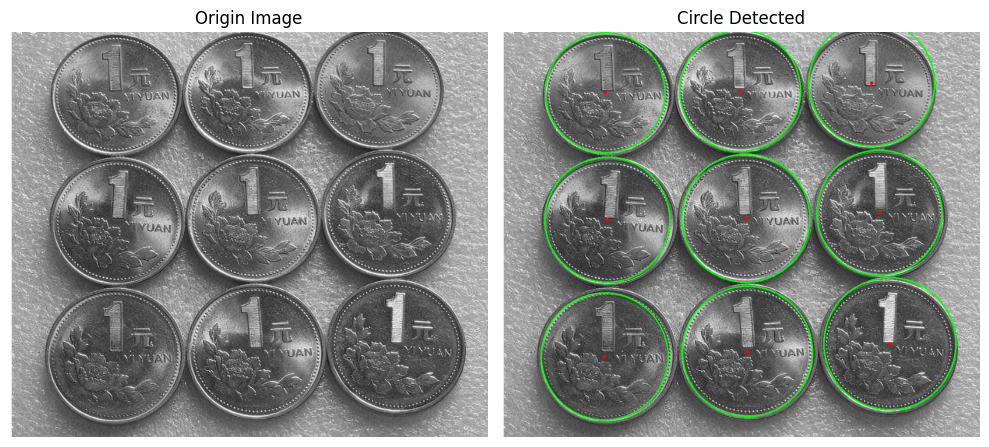

CPU times: user 8.79 s, sys: 431 ms, total: 9.22 s
Wall time: 8.97 s
----------------------------------------------------------------------------------------------------


voting: 100%|██████████| 5163/5163 [00:02<00:00, 2512.69it/s]
filter circle: 1895it [00:00, 21546.39it/s]


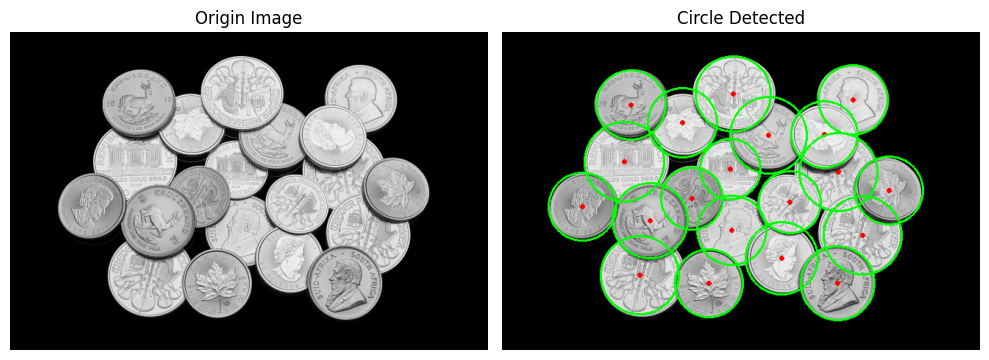

CPU times: user 4.18 s, sys: 250 ms, total: 4.43 s
Wall time: 4.19 s
----------------------------------------------------------------------------------------------------


voting: 100%|██████████| 35284/35284 [00:09<00:00, 3858.29it/s]
filter circle: 2024it [00:00, 9456.98it/s]


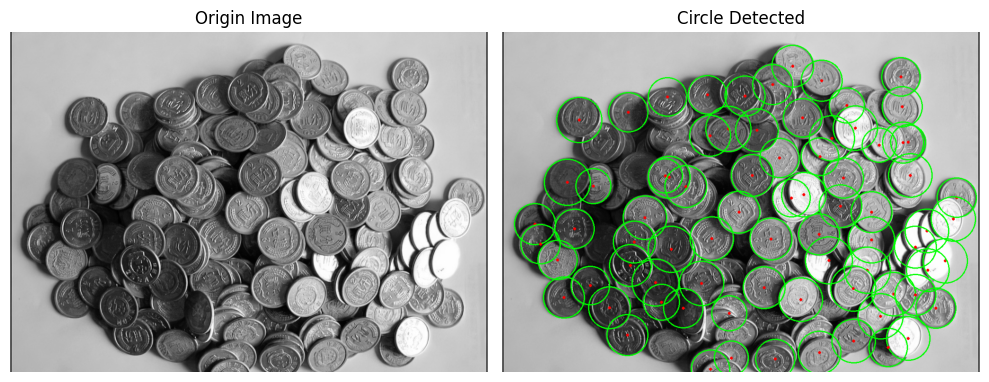

CPU times: user 15.2 s, sys: 404 ms, total: 15.6 s
Wall time: 15.3 s
----------------------------------------------------------------------------------------------------


In [3]:
for k, v in config.items():
    img = cv2.imread(k, cv2.IMREAD_GRAYSCALE)
    %time circles = hough_circle(img, **v, quiet=True)  # 只展示结果
    print("-" * 100)

## 测试性能：运行时间

使用魔术命令%timeit测试运算时间并和opencv对比,可以发现opencv速度非常快，但是python速度也还能接受

In [4]:
%%timeit 
%%capture 
# opencv例子
img = cv2.imread("./img/coins5.jpg", cv2.IMREAD_GRAYSCALE)
circles = cv2.HoughCircles(
    img,
    cv2.HOUGH_GRADIENT,
    dp=1,  # 图像分辨率和累加器分辨率比
    minDist=50,  # 被检测的圆心之间的最小距离
    param1=130,  # 传递给canny中的较高的阈值,低阈值是高阈值的一半
    param2=70,  # 检测阶段圆心的投票阈值，越小，错误的圆越多
    minRadius=30,  # 最小圆半径
    maxRadius=100,  # 最大圆半径
)
circles = np.uint16(np.around(circles))
img_c = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for i in circles[0, :]:
    cv2.circle(img_c, (i[0], i[1]), i[2], (0, 255, 0), 2)
    cv2.circle(img_c, (i[0], i[1]), 2, (0, 0, 255), 2)
plt.imshow(img_c, "gray"), plt.axis("off"), plt.show()

82.5 ms ± 836 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit
%%capture
img_path = "./img/coins5.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
circles = hough_circle(img, **config[img_path])

4.01 s ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 展示调试过程

使用`debugging=True`参数设置对应函数为调试模式，调试模式可以输出图像数据像素的灰度分布等信息，通过这样的方法可以方便的调整参数，从而实现更好的检测效果

各个调试选项的含义
- `debugging`: 详细输出每一步的图像，并作柱形图分析图像的像素值分布
- `vt_debugging`: 使用不同的最小投票阈值，画出检测到的圆，从而选出最佳阈值
    - `vtd_step`: 调试中阈值步进的量
- `quiet`: 设置为True可以屏蔽上述调试选项，并只输出最少的信息，即原图和检测到的圆

默认debugging为False，此时输出原图，检测到的边缘和检测到的圆。


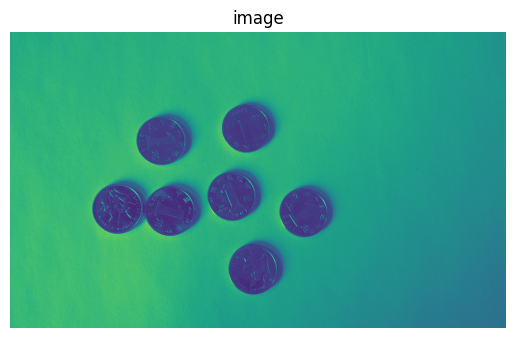

uint8
(612, 1024)


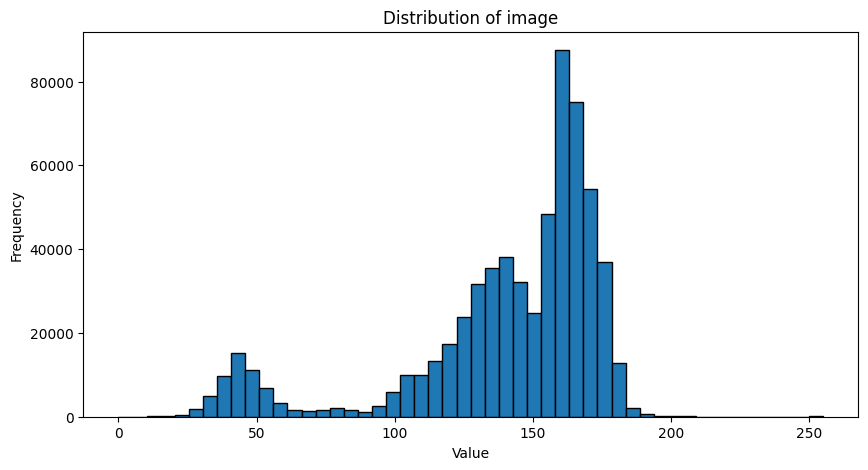

min0,max255
----------------------------------------------------------------------------------------------------
[[0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.03144654 0.0754717  0.09433962 0.0754717  0.03144654]
 [0.02515723 0.05660377 0.0754717  0.05660377 0.02515723]
 [0.01257862 0.02515723 0.03144654 0.02515723 0.01257862]]
image shape:(612, 1024)


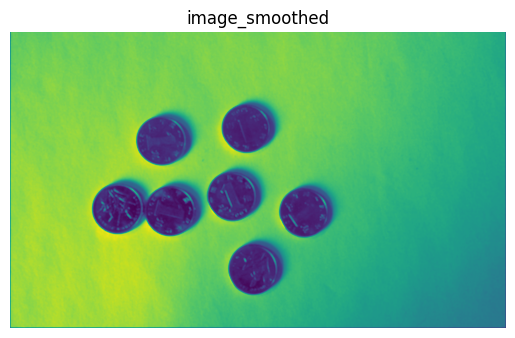

float32
(612, 1024)


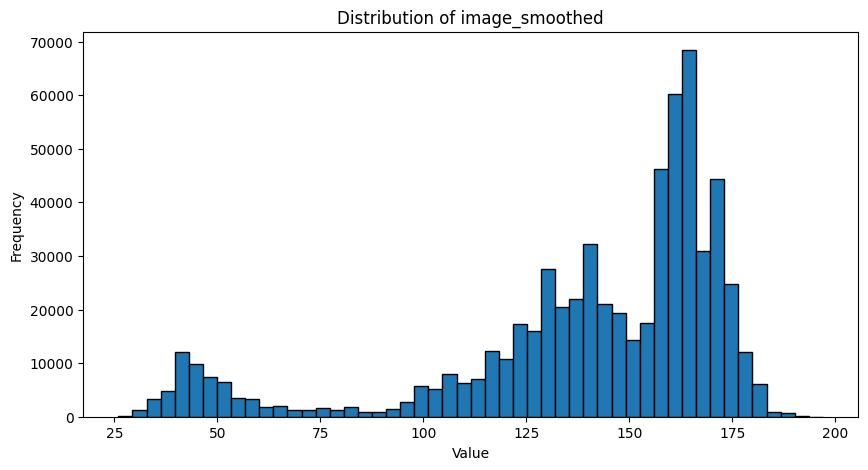

min26.0,max197.0
----------------------------------------------------------------------------------------------------


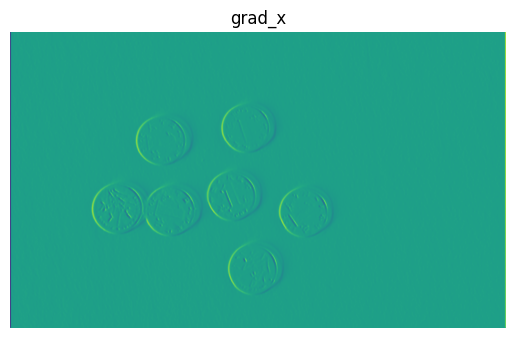

float32
(612, 1024)


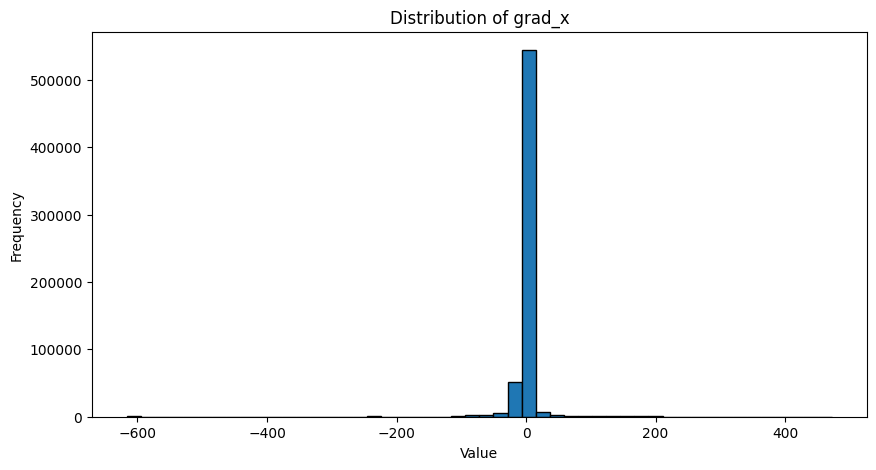

min-616.0,max472.0
----------------------------------------------------------------------------------------------------


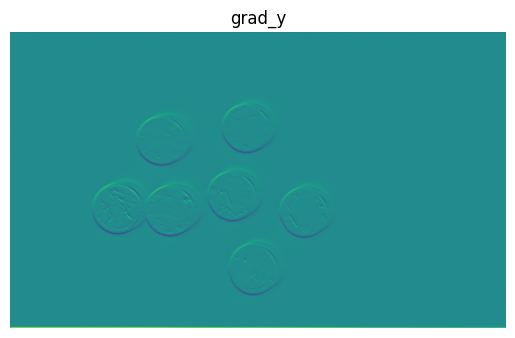

float32
(612, 1024)


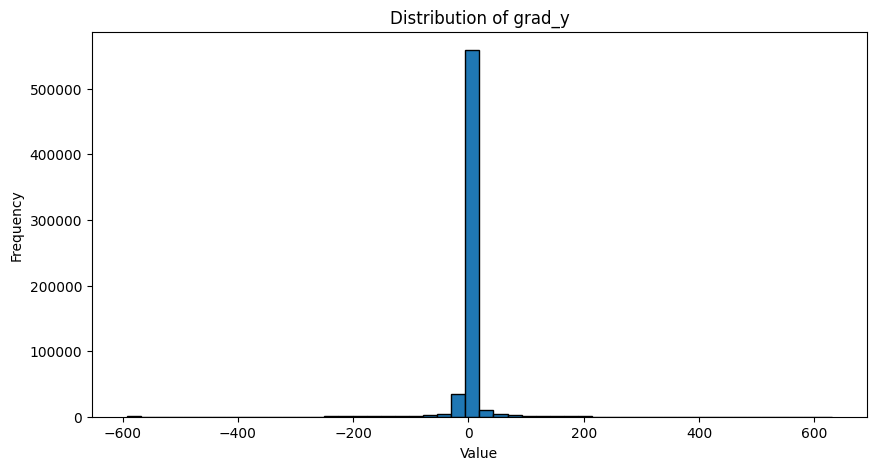

min-592.0,max630.0
----------------------------------------------------------------------------------------------------


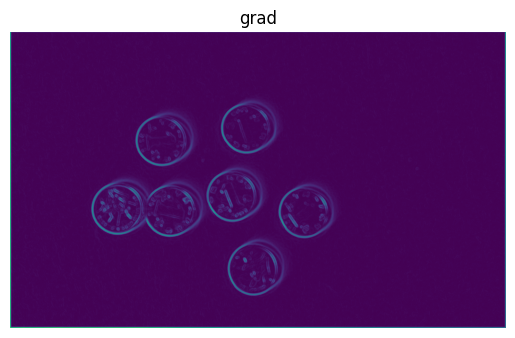

float32
(612, 1024)


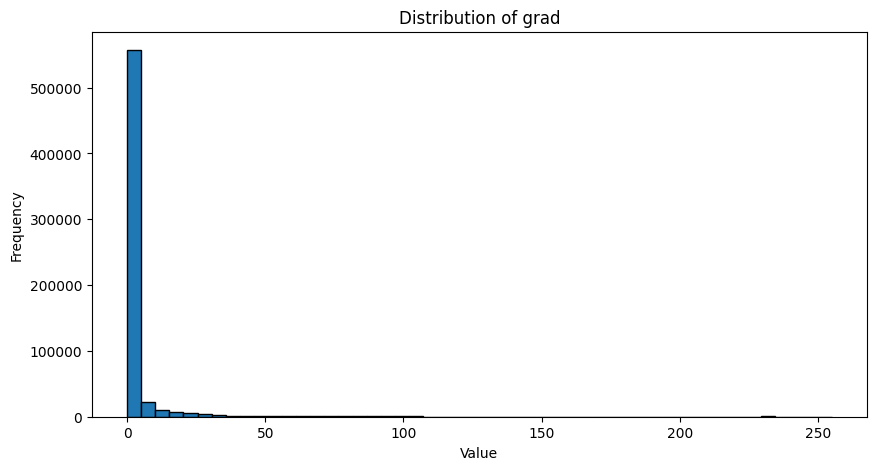

min0.0,max255.0
----------------------------------------------------------------------------------------------------
float32
(612, 1024)


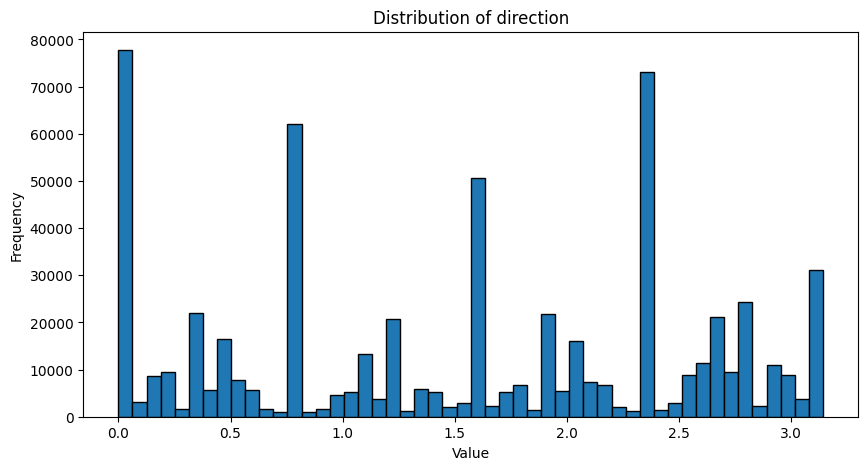

min0.0,max3.1415927410125732
----------------------------------------------------------------------------------------------------


nms calculating: 100%|██████████| 610/610 [00:04<00:00, 147.14it/s]


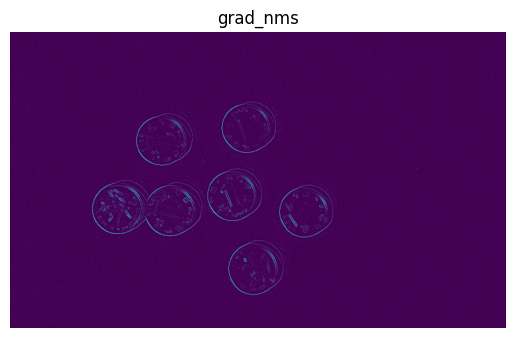

float64
(612, 1024)


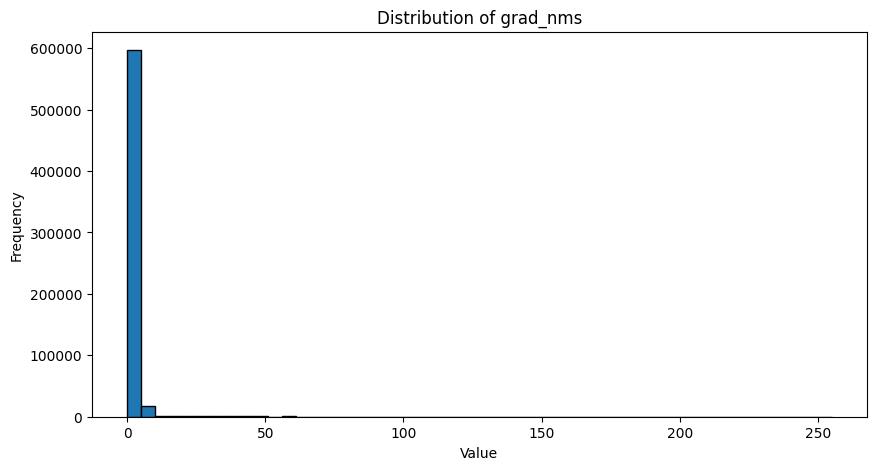

min0.0,max255.0
----------------------------------------------------------------------------------------------------


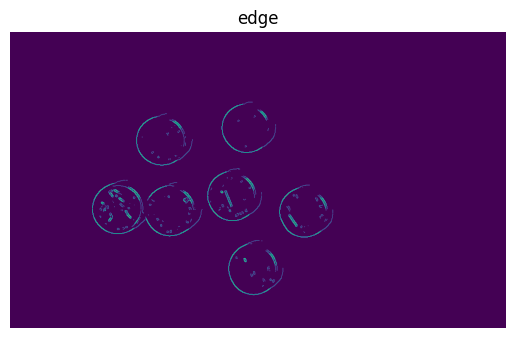

int32
(612, 1024)


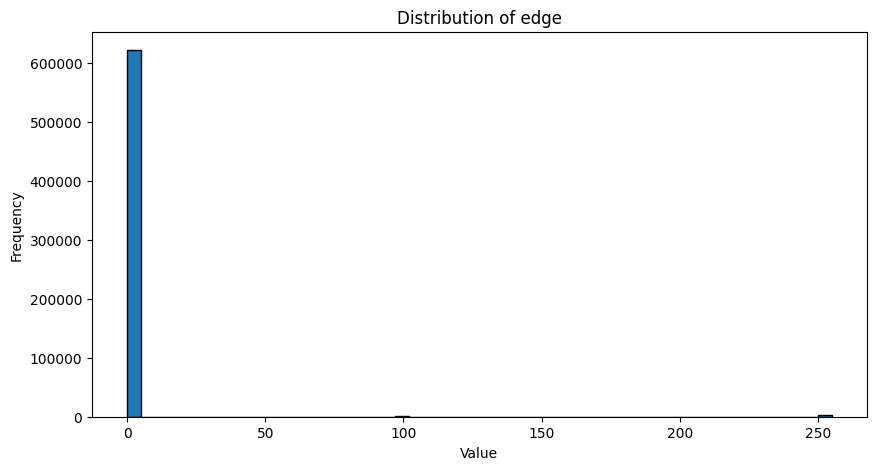

min0,max255
----------------------------------------------------------------------------------------------------


voting: 100%|██████████| 2355/2355 [00:05<00:00, 457.49it/s]


int32
(20235,)


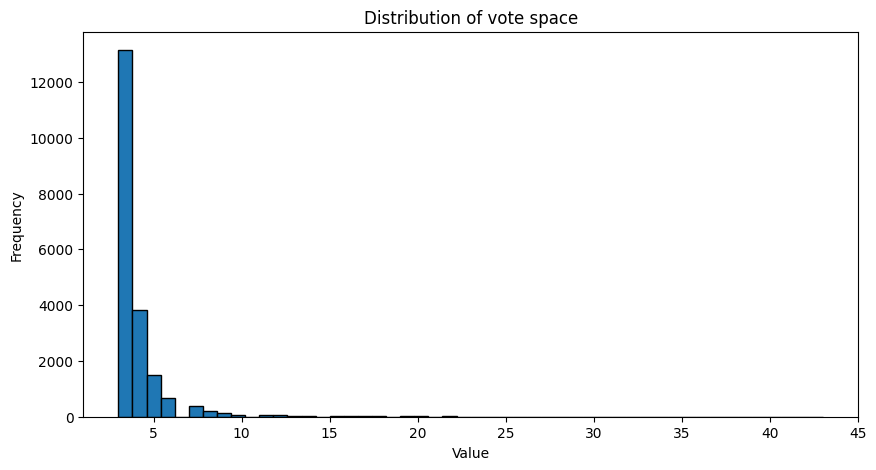

min3,max43
----------------------------------------------------------------------------------------------------
int32
(1761,)


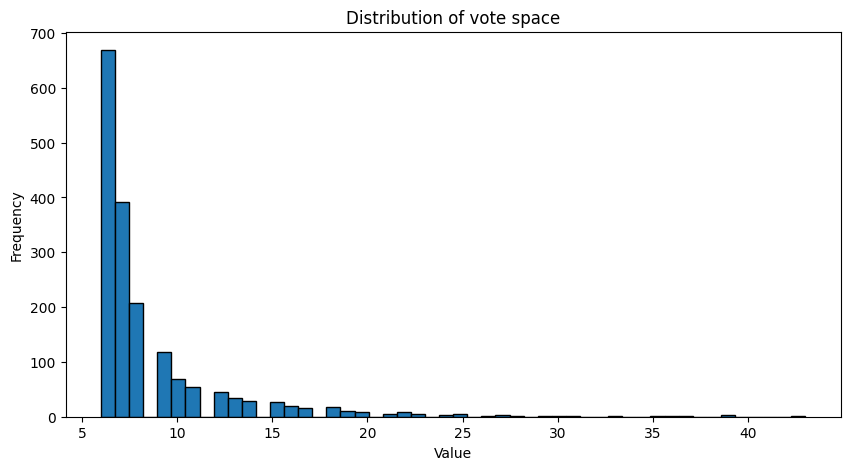

min6,max43
----------------------------------------------------------------------------------------------------
int32
(494,)


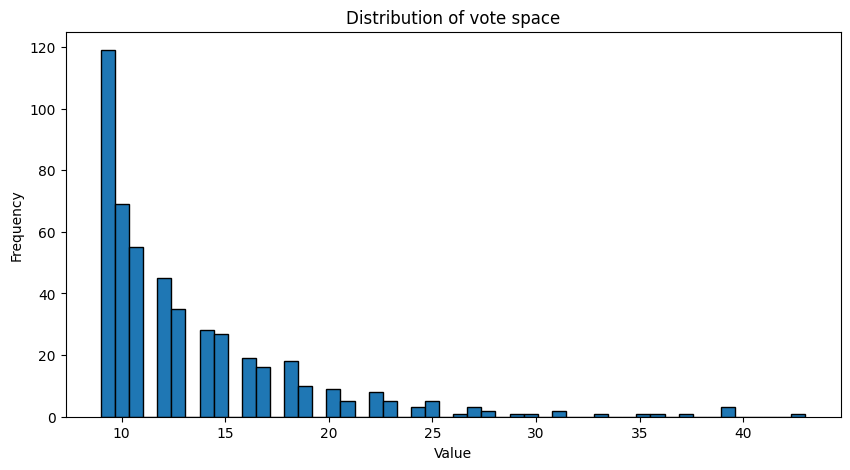

min9,max43
----------------------------------------------------------------------------------------------------
int32
(251,)


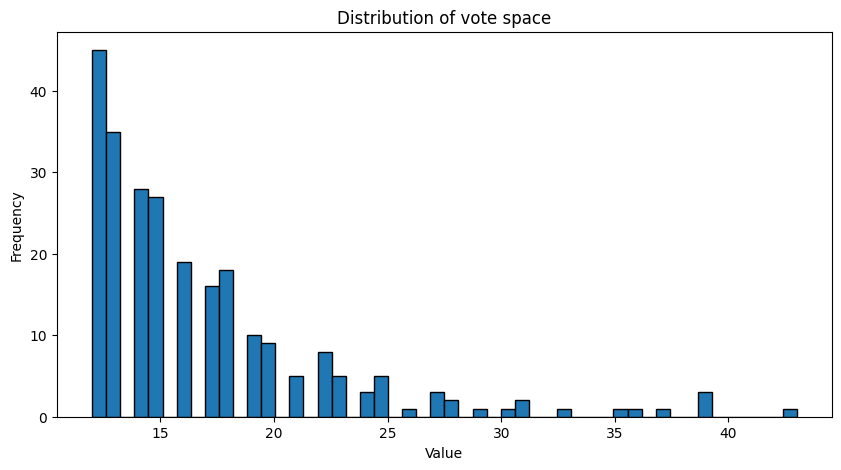

min12,max43
----------------------------------------------------------------------------------------------------
int32
(143,)


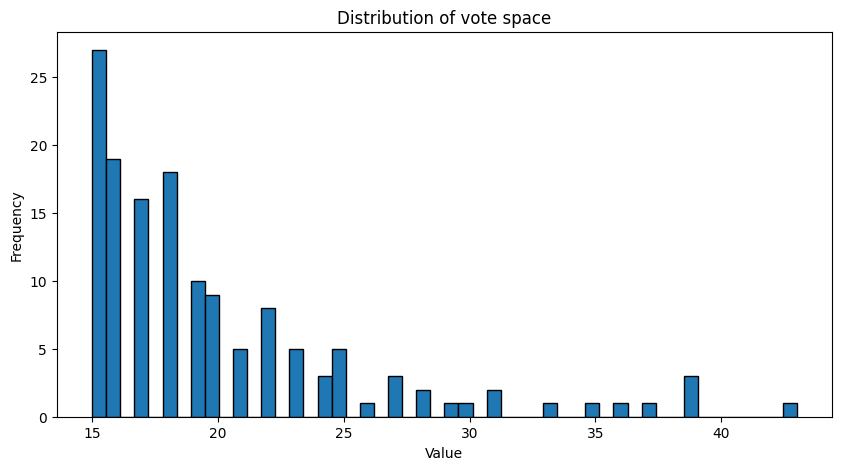

min15,max43
----------------------------------------------------------------------------------------------------
int32
(81,)


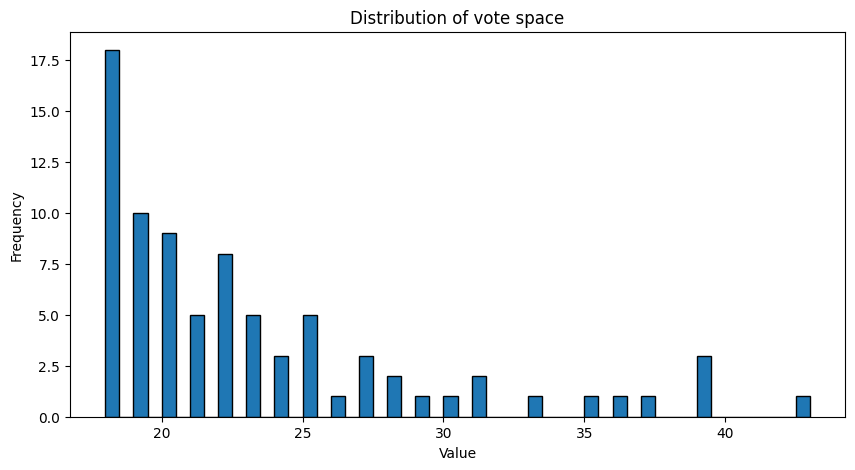

min18,max43
----------------------------------------------------------------------------------------------------
voting threshold:5


filter circle: 1761it [00:00, 9011.71it/s]


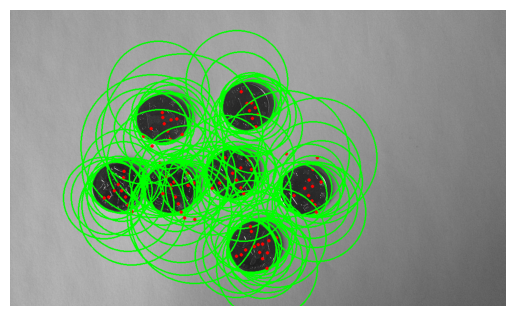

Above circles: min_r51,max_r166
----------------------------------------------------------------------------------------------------
voting threshold:8


filter circle: 494it [00:00, 21725.54it/s]


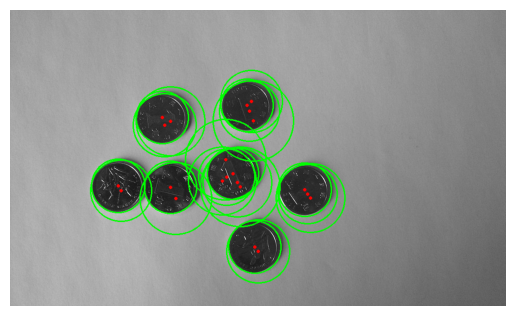

Above circles: min_r53,max_r83
----------------------------------------------------------------------------------------------------
voting threshold:11


filter circle: 251it [00:00, 32976.36it/s]


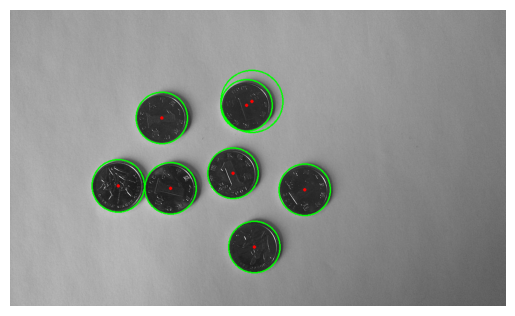

Above circles: min_r52,max_r64
----------------------------------------------------------------------------------------------------
voting threshold:14


filter circle: 143it [00:00, 27760.13it/s]


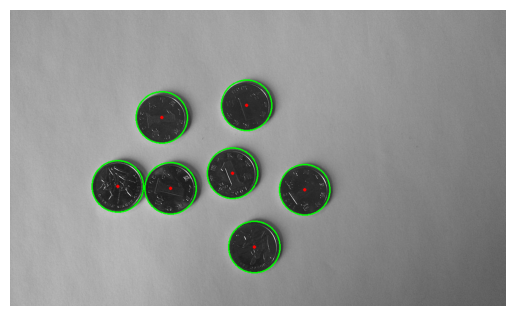

Above circles: min_r52,max_r53
----------------------------------------------------------------------------------------------------
voting threshold:17


filter circle: 81it [00:00, 34578.99it/s]


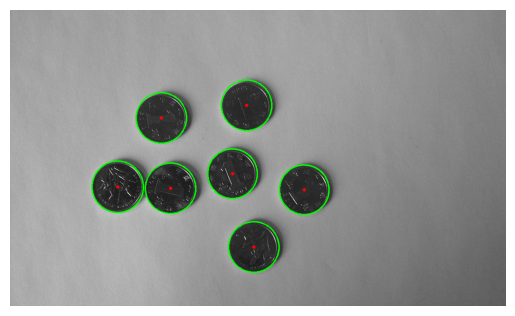

Above circles: min_r51,max_r53
----------------------------------------------------------------------------------------------------
voting threshold:20


filter circle: 44it [00:00, 22764.20it/s]


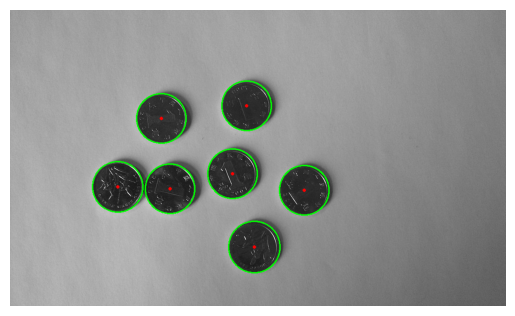

Above circles: min_r51,max_r53
----------------------------------------------------------------------------------------------------
voting threshold:23


filter circle: 26it [00:00, 21637.28it/s]


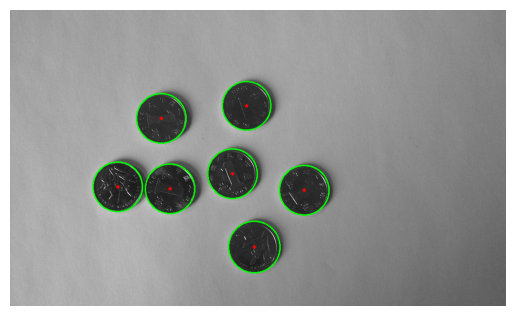

Above circles: min_r50,max_r53
----------------------------------------------------------------------------------------------------
voting threshold:26


filter circle: 17it [00:00, 14127.83it/s]


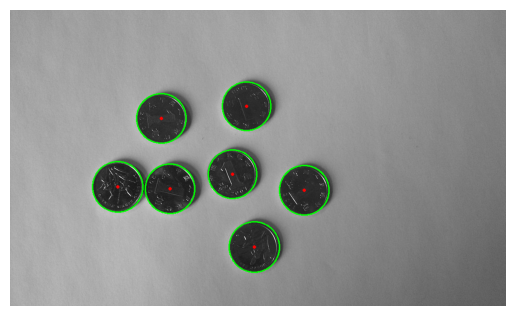

Above circles: min_r50,max_r52
----------------------------------------------------------------------------------------------------
voting threshold:29


filter circle: 11it [00:00, 17037.42it/s]


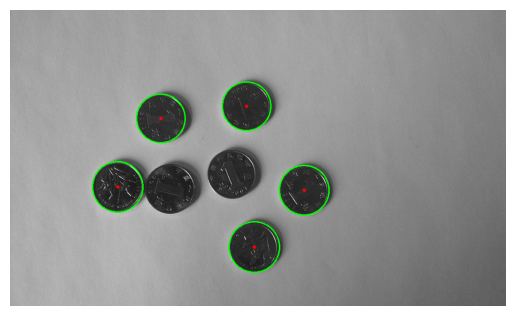

Above circles: min_r50,max_r52
----------------------------------------------------------------------------------------------------
voting threshold:32


filter circle: 8it [00:00, 16513.01it/s]


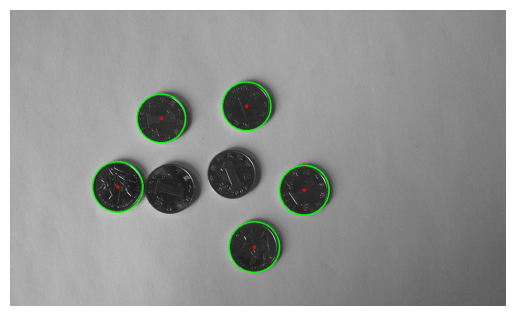

Above circles: min_r50,max_r52
----------------------------------------------------------------------------------------------------
voting threshold:35


filter circle: 6it [00:00, 15224.33it/s]


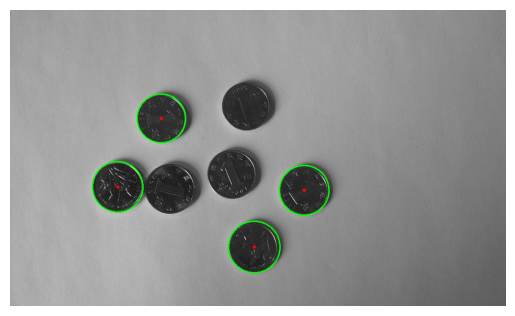

Above circles: min_r50,max_r53
----------------------------------------------------------------------------------------------------
voting threshold:38


filter circle: 4it [00:00, 12846.26it/s]


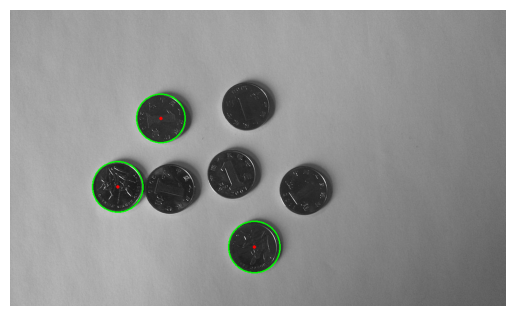

Above circles: min_r50,max_r53
----------------------------------------------------------------------------------------------------
voting threshold:41


filter circle: 1it [00:00, 3480.75it/s]


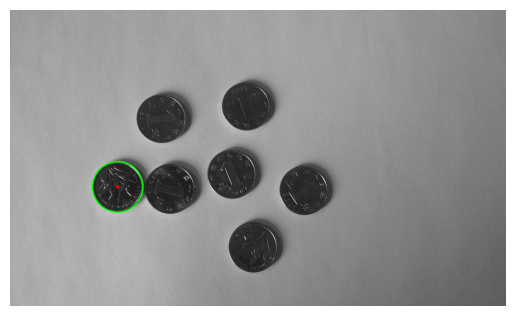

Above circles: min_r52,max_r52
----------------------------------------------------------------------------------------------------


In [6]:
img_path = "./img/coins2.jpg"
# test hough
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
circles = hough_circle(
    img,
    high_threshold=100,
    low_threshold=50,
    min_r=50,
    max_r=200,
    min_voting=17,  # 实际上在vt_debugging=True的情况下不起作用
    debugging=True,
    vt_debugging=True,
    vtd_step=3,
)